In [206]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

In [207]:
#data/datasets/dataset_SocialGolfers-2024-05-16.json
#data/datasets/dataset_CoveringArray-2024-05-09.json
#data/datasets/dataset_CarSequencing-2024-04-16.json
f = open("../data/datasets/dataset_SocialGolfers-2024-05-16.json")
dataset = json.load(f)
f.close()

In [208]:
def load_folder(folder):
    files = os.listdir(folder)
    res = {}
    for file in files:
        path = os.path.join(folder, file)
        if os.path.isdir(path):
            res[file] = load_folder(path)
        else:
            f = open(path)
            res[file] = json.load(f)
            f.close()
    return res

In [209]:
predictions = load_folder("../predictions/SocialGolfers")

In [210]:
instance_dataset = {}
for datapoint in dataset:
    inst = datapoint["instance_name"]
    times = {t["combination"]: t["time"] for t in datapoint["all_times"]}
    instance_dataset[inst] = times

In [211]:
combinations = [t["combination"] for t in dataset[0]["all_times"]]

In [212]:
# combinations.pop(combinations.index("chuffed_06_chPrunedLevels.eprime"))
# combinations.pop(combinations.index("cplex_06_chPrunedLevels.eprime"))
# combinations.pop(combinations.index("kissat_06_chPrunedLevels.eprime"))
# combinations.pop(combinations.index("or-tools-1_06_chPrunedLevels.eprime"))

In [213]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
metrics = {"accuracy": accuracy_score, "recall": recall_score, "f1": f1_score, "precision": precision_score}

In [214]:
def is_competitive(vb, option):
    return (option < 10 or vb * 2 >= option) and option < 3600

In [215]:
combinations = sorted(combinations)

In [216]:
combinations

['chuffed_01_compact.eprime',
 'chuffed_04_nochPrunedLevels_2.eprime',
 'chuffed_04_nochPrunedLevels_3.eprime',
 'chuffed_06_chPrunedLevels_1_2.eprime',
 'cplex_01_compact.eprime',
 'cplex_04_nochPrunedLevels_2.eprime',
 'cplex_04_nochPrunedLevels_3.eprime',
 'cplex_06_chPrunedLevels_1_2.eprime',
 'kissat_01_compact.eprime',
 'kissat_04_nochPrunedLevels_2.eprime',
 'kissat_04_nochPrunedLevels_3.eprime',
 'kissat_06_chPrunedLevels_1_2.eprime',
 'or-tools-1_01_compact.eprime',
 'or-tools-1_04_nochPrunedLevels_2.eprime',
 'or-tools-1_04_nochPrunedLevels_3.eprime',
 'or-tools-1_06_chPrunedLevels_1_2.eprime']

In [217]:
predictions.keys()

dict_keys(['autofolio_untuned_fzn2feat', 'autofolio_untuned_dnn_fully_neural', 'autofolio_tuned_dnntanhpredictions', 'autofolio_tuned_fully_neural', 'kmeans_fzn2feat', 'autofolio_tuned_fzn2feat', 'kmeans_dnn_fully_neural', 'autofolio_untuned_dnntanhpredictions', 'fully_neural', 'kmeans_dnntanhpredictions'])

In [218]:
SAMPLE_KEY = list(predictions.keys())[1]
fold_instances = {"train": {i: [] for i in range(10)}, "validation": {i: [] for i in range(10)}, "test": {i: [] for i in range(10)}} #fold: instances of the fold
for key in predictions[SAMPLE_KEY]:
    strip = key.replace("_predictions_fold", "")
    strip = strip.split("_")
    set_type, fold = strip[0], int(strip[1])
    for pred in predictions[SAMPLE_KEY][key]: 
        instance = pred["inst"]
        fold_instances[set_type][fold].append(instance)

In [219]:
preditions_dataset = {}
for selection_algorithm in predictions.keys():
    if not selection_algorithm in preditions_dataset:
        preditions_dataset[selection_algorithm] = {}
    for set_type_prediction_fold in predictions[selection_algorithm]:
        strip = set_type_prediction_fold.replace("_predictions_fold", "")
        strip = strip.split("_")
        set_type, fold = strip[0], int(strip[1])
        if not set_type in preditions_dataset[selection_algorithm]:
            preditions_dataset[selection_algorithm][set_type] = {}
        if not fold in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][fold] = []
        for pred in predictions[selection_algorithm][set_type_prediction_fold]:
            inst = pred["inst"]
            choosen_option = pred["chosen_option"]
            pred_time = pred["time"] if "time" in pred else 0
            if inst in fold_instances[set_type][fold]:
                preditions_dataset[selection_algorithm][set_type][fold].append(
                    instance_dataset[inst][choosen_option] + pred_time
                )
for selection_algorithm in preditions_dataset:
    for set_type in preditions_dataset[selection_algorithm]:
        for fold in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][fold] = sum(preditions_dataset[selection_algorithm][set_type][fold])

In [220]:
for combination in combinations:
    preditions_dataset[combination] = {}
    for set_type in fold_instances.keys():
        preditions_dataset[combination][set_type] = {}
        for fold in fold_instances[set_type].keys():
            preditions_dataset[combination][set_type][fold] = []
            for inst in fold_instances[set_type][fold]:
                preditions_dataset[combination][set_type][fold] += [instance_dataset[inst][combination]]
            preditions_dataset[combination][set_type][fold] = sum(preditions_dataset[combination][set_type][fold])
     
preditions_dataset["virtual best"] = {}       
for set_type in fold_instances.keys():
    preditions_dataset["virtual best"][set_type] = {}
    for fold in fold_instances[set_type].keys():
        preditions_dataset["virtual best"][set_type][fold] = []
        for inst in fold_instances[set_type][fold]:
            preditions_dataset["virtual best"][set_type][fold] += [min(instance_dataset[inst].values())]
        preditions_dataset["virtual best"][set_type][fold] = sum(preditions_dataset["virtual best"][set_type][fold])

In [221]:
def key_transform_p1(key):
    if "eprime" in key:
        key = key.replace("0","M").replace("or-tools-1","OR-Tools").replace("5","3").replace("cplex", "CPLEX").replace("chuffed", "Chuffed").replace("kissat", "Kissat")
        return "-".join(key.split("_")[:2])
    else:
        return key.replace("_", "-")
def key_transform(key):
    k = key_transform_p1(key)
    if key != "virtual best":
        string =  "-".join([k.split("-")[-1]] + k.split("-")[:-1])
        return string
    return key.replace("virtual best", "VBS")

In [223]:
def transform(name:str) -> str:
    if "eprime" in name:
        return r"$SB$"
    if "virtual best" in name:
        return r"$VB$"
    if "fully_neural" == name:
        return f"(NN, NN)"
    features = ""
    algorithm = ""
    if "fully_neural" in name:
        features = "NN"
    elif "tanh" in name:
        features = "cNN"
    elif "fzn2feat" in name:
        features = "fzn2feat"
    else:
        raise Exception(f"features {name} unrecognized")
    if "autofolio_untuned" in name:
        algorithm = "A"
    elif "autofolio_tuned" in name:
        algorithm = "A^T"
    elif "kmeans" in name:
        algorithm = "K"
    else:
        raise Exception(f"algorithm {name} unrecognized")
    return fr"(${features}, {algorithm}$)"

kissat_04_nochPrunedLevels_2.eprime


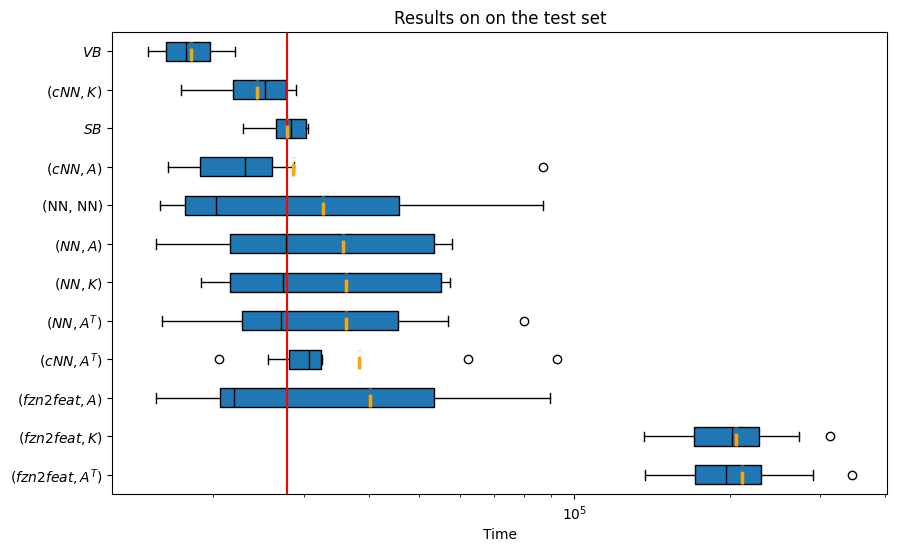

In [226]:
set_to_use = "test"
test_predictions = {}
opt_times = {comb["combination"]:0 for comb in dataset[0]["all_times"]}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        opt_times[t["combination"]] += t["time"]
sb_key = min(opt_times.items(), key = lambda x: x[1])[0]
print(sb_key)
for key in preditions_dataset.keys():
    try:
        if not key in combinations or key == sb_key:
            test_predictions[transform(key)] = list(preditions_dataset[key][set_to_use].values())
    except:
        print(key)
        
plot = []

sorted_data = dict(sorted(test_predictions.items(), key=lambda item: sum(item[1]) / len(item[1]), reverse=True))

v_line = np.mean(test_predictions["$SB$"])
plt.figure(figsize=(10, 6))
plt.boxplot(list(sorted_data.values()), 
            vert=False, 
            patch_artist=True, 
            showmeans=True, 
            meanprops=dict(linestyle='--', linewidth=2.5, color='orange'), 
            boxprops=dict(facecolor="#1F78B4"), 
            meanline=True,
            medianprops=dict(color='black'))

plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))

plt.xscale("log")
plt.axvline(v_line, color="red")
plt.xlabel('Time')
plt.ylabel('')
plt.title(f"Results on on the {set_to_use} set")
plt.savefig(f"results_{set_to_use}_SocialGolfers.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [4]:
f = open("../data/datasets/dataset_EFPA-2024-05-16.json")
data = json.load(f)
f.close()
comps = {c["combination"]:0 for c in data[0]["all_times"]}
temps = {c["combination"]:0 for c in data[0]["all_times"]}
top_3 =  ['kissat_01_compact.eprime',
  'chuffed_01_compact.eprime',
  'cplex_01_compact.eprime']
vbs_limited = 0
vbs = 0
  
for d in data:
    vb = min(d["all_times"], key= lambda x: x["time"])["time"]
    vbs += vb
    vbs_limited += min([t["time"] for t in d["all_times"] if t["combination"] in top_3])
    for t in d["all_times"]:
        temps[t["combination"]] += t["time"]
        if is_competitive(vb, t["time"]):
            comps[t["combination"]] += 1
temps = {k:v for k,v in sorted(temps.items(), key= lambda x: x[1])}
vbs, vbs_limited, vb/vbs_limited

(205406.55000000025, 205481.03000000023, 5.523624248914845e-05)

In [14]:
import json
import pandas as pd
f = open("../data/datasets/dataset_AbnormalMagicHexagons-2024-05-16.json")
data = json.load(f)
f.close()
def is_competitive(vb, option):
    return vb * 1.3 >= option and option < 3600
comps = {t["combination"]:0 for t in data[0]["all_times"]}
for datapoint in data:
    all_times = datapoint["all_times"]
    vb = min(all_times, key= lambda x: x["time"])["time"]
    for t in all_times:
        if is_competitive(vb, t["time"]):
            comps[t["combination"]] += 1
comps = sorted([{"algorithm":k, "competitives":v} for k, v in comps.items()], key = lambda x: x["competitives"], reverse=True)
df = pd.DataFrame(comps)
display(df)
len(data)

,algorithm,competitives
0,chuffed_01_compact.eprime,1145
1,kissat_01_compact.eprime,1133
2,or-tools-1_01_compact.eprime,1082
3,cplex_01_compact.eprime,97


1206

In [259]:
train_predictions = preditions_dataset["train"]
validation_predictions = preditions_dataset["validation"]
test_predictions = preditions_dataset["test"]
full = {k: [] for k in train_predictions.keys()}
for i in range(10):
    for k in train_predictions.keys():
        try:
            full[k].append(train_predictions[k][i] + validation_predictions[k][i] + test_predictions[k][i])
        except:
            print(k)

In [260]:
full_times = {comb: 0 for comb in combinations}
full_times["virtual best"] = 0
for datapoint in dataset:
    for t in datapoint["all_times"]:
        if t["combination"] in full_times:
            full_times[t["combination"]] += t["time"] 
    full_times["virtual best"] += datapoint["time"]
            
full_times = {k:v for k, v in sorted(full_times.items(), key=lambda x: x[1], reverse=True)}

In [261]:
full_times

{'cplex_02_compact.eprime': 367704000,
 'kissat_05_nochAllLevels_2.eprime': 222768999.8000004,
 'or-tools-1_05_nochAllLevels_2.eprime': 219966419.0099998,
 'chuffed_05_nochAllLevels_2.eprime': 219775354.7399997,
 'cplex_05_nochAllLevels_2.eprime': 219364389.46999943,
 'cplex_01_compact.eprime': 61455015.5600002,
 'kissat_02_compact.eprime': 34423507.530000165,
 'kissat_01_compact.eprime': 28051232.540000096,
 'or-tools-1_02_compact.eprime': 11559523.760000011,
 'chuffed_01_compact.eprime': 10367831.069999991,
 'or-tools-1_01_compact.eprime': 8301687.569999984,
 'chuffed_02_compact.eprime': 7404031.23000001,
 'virtual best': 108953.03000000032}

In [262]:
def key_sorter(x):
    k = key_transform(x[0])
    if x[0] != "virtual best":
        return k
    else:
        return "M0"
    
def get_color_solver(k):
    if "chuffed" in k:
        return 0
    if "cplex" in k:
        return 1
    if "or-tools" in k:
        return 2
    if "kissat" in k:
        return 3
    return 4

def get_color_model(k):
    if "M1" in k:
        return 0
    if "M2" in k:
        return 1
    if "M3" in k:
        return 2
    return 3

def key_sorter_model(x):
    if x[0] != "virtual best":
        return x[0]
    else:
        return "M0"autofolio_tuned_dnntanh
    return x + (" " * (max - l))

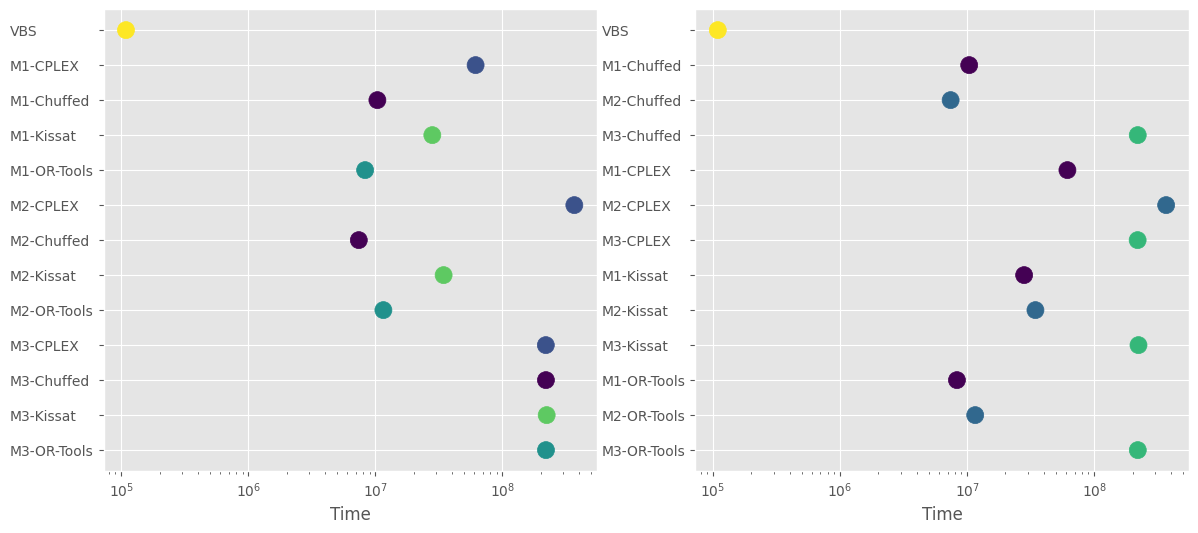

In [263]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
full_times = {k:v for k,v in sorted(full_times.items(), key= key_sorter, reverse=True)}
colors = [get_color_solver(k) for k in full_times.keys()]
s = [150 for _ in range(13)]
pad_len = max([len(key_transform(k)) for  k in full_times.keys()])
axs[0].scatter(list(full_times.values()), [key_transform(k) for  k in full_times.keys()], c=colors, s=s)
axs[0].grid(True)
for label in axs[0].get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
axs[0].set_xscale("log")
axs[0].set_xlabel("Time")

full_times = {k:v for k,v in sorted(full_times.items(), key= key_sorter_model, reverse=True)}
colors = [get_color_model(key_transform(k)) for k in full_times.keys()]
s = [150 for _ in range(13)]
axs[1].scatter(list(full_times.values()), [key_transform(k) for  k in full_times.keys()], c=colors, s=s)
axs[1].grid(True)
for label in axs[1].get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
axs[1].set_xscale("log")
axs[1].set_xlabel("Time")
fig.savefig("algorithm_time.pdf", format="pdf")

In [264]:
all_wins = {comb: 0 for comb in combinations}
for datapoint in dataset:
    win_comb = datapoint["combination"]
    win_comb = win_comb.replace("06_chPrunedLevels", "01_compact")
    all_wins[win_comb] += 1

all_wins = {comb: v/len(dataset) for comb, v in all_wins.items()}
all_wins

{'chuffed_01_compact.eprime': 0.38887801057372234,
 'chuffed_02_compact.eprime': 0.007930291756412767,
 'chuffed_05_nochAllLevels_2.eprime': 0.0,
 'cplex_01_compact.eprime': 0.2781476404934404,
 'cplex_02_compact.eprime': 0.0,
 'cplex_05_nochAllLevels_2.eprime': 0.0,
 'kissat_01_compact.eprime': 0.01732915606030938,
 'kissat_02_compact.eprime': 0.0007832386919913843,
 'kissat_05_nochAllLevels_2.eprime': 0.0,
 'or-tools-1_01_compact.eprime': 0.306637947914627,
 'or-tools-1_02_compact.eprime': 0.00029371450949676914,
 'or-tools-1_05_nochAllLevels_2.eprime': 0.0}

In [265]:
all_competitive = {comb: 0 for comb in combinations}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        if not "06_chPrunedLevels" in t["combination"]:
            if is_competitive(datapoint["time"], t["time"]):
                all_competitive[t["combination"]] += 1
all_competitive = {comb: v/len(dataset) for comb, v in all_competitive.items()}
all_competitive

{'chuffed_01_compact.eprime': 0.5522811826904249,
 'chuffed_02_compact.eprime': 0.459271588016448,
 'chuffed_05_nochAllLevels_2.eprime': 0.023007636577246915,
 'cplex_01_compact.eprime': 0.8330722537693362,
 'cplex_02_compact.eprime': 0.0,
 'cplex_05_nochAllLevels_2.eprime': 0.02535735265322107,
 'kissat_01_compact.eprime': 0.47160759741531233,
 'kissat_02_compact.eprime': 0.41629136479342077,
 'kissat_05_nochAllLevels_2.eprime': 0.022322302721754454,
 'or-tools-1_01_compact.eprime': 0.5173291560603094,
 'or-tools-1_02_compact.eprime': 0.4158018406109262,
 'or-tools-1_05_nochAllLevels_2.eprime': 0.02349716075974153}

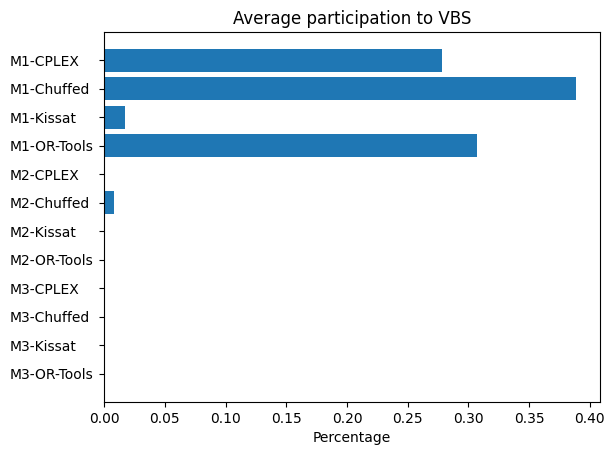

In [266]:
all_wins = {k:v for k,v in sorted(all_wins.items(), key=lambda x: key_transform(x[0]), reverse=True)}
plt.style.use('default')
plt.barh([key_transform(k) for k in all_wins.keys()], list(all_wins.values()))
for label in plt.gca().get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
plt.title("Average participation to VBS")
plt.xlabel("Percentage")
plt.savefig("algorithm_wins_vb.pdf", format="pdf", bbox_inches='tight')

In [4]:
f = open("../test_predictions_fold_5")
new_preds = json.load(f)
f.close()
f = open("../predictions/autofolio_smac_dnn/test_predictions_fold_5")
old_preds = json.load(f)
f.close()

In [7]:
tot_new = 0
for p in new_preds:
    tot_new += instance_dataset[p["inst"]][p["chosen_option"]]
tot_old = 0
for p in old_preds:
    tot_old += instance_dataset[p["inst"]][p["chosen_option"]]
print(tot_new)
print(tot_old)

341735.37000000005
122547.38000000005


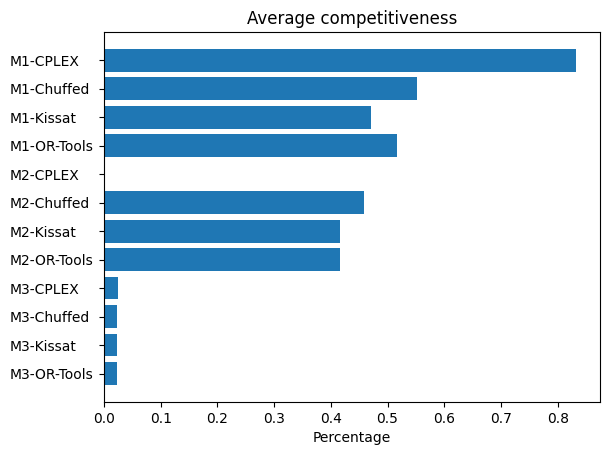

In [ ]:
all_competitive = {k:v for k,v in sorted(all_competitive.items(), key=lambda x: key_transform(x[0]), reverse=True)}
plt.barh([key_transform(k) for k in all_competitive.keys()], list(all_competitive.values()))
for label in plt.gca().get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.17,0))
plt.xlabel("Percentage")
plt.title("Average competitiveness")
plt.savefig("algorithm_comp_vb.pdf", format="pdf", bbox_inches='tight')

In [ ]:
training_data = {}
for file in os.listdir("../history"):
    if "extra" in file:
        continue
    fold = file.split("_mult_")[0].replace("fold_","")
    mult = 2 if "2" in file.split("_mult_")[1] else 1
    time = "init" if "init" in file.split("_mult_")[1] else "fin"
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join("../history", file))
    if mult == 2:
        training_data[fold][0] = json.load(f)
    elif mult == 1:
        if time == "init":
            training_data[fold][1] = json.load(f)
        else:
            training_data[fold][2] = json.load(f)
    f.close()

In [ ]:
for fold in training_data.keys():
    res = []
    for i in range(3):
        res += [training_data[fold][i]]
    training_data[fold] = res
# del training_data["8"]

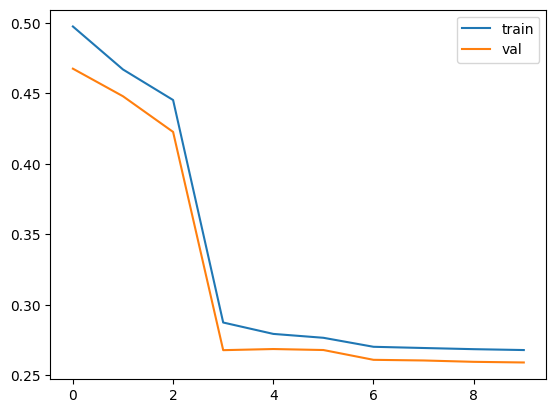

In [ ]:
loss_train = []
loss_val = []
for v in training_data["7"]:
    loss_train += v["train"]["loss"]
    loss_val += v["validation"]["loss"]
x = [i for i in range(len(loss_train))]
plt.plot(x, loss_train, label="train")
plt.plot(x, loss_val, label="val")
plt.legend()
plt.show()

# Faulty

In [ ]:
times_epocs = {
    0: {
        "train": [8132784.64, 8850910.27, 9007208.57, 8998482.49, 9010782.31, 8962279.73, 8959317.20, 8947491.66, 8944376.73, 8932231.46],
        "sb_train": 6213070.61,
        "vb_train": 88758.17,
        "validation": [916496.05, 899841.56, 899841.56, 899878.59, 897891.84, 901015.08, 900360.10, 899291.87, 899757.12, 901092.68],
        "sb_validation": 539525.83,
        "vb_validation": 9268.37,
        "test": [1318550.38, 1299450.09, 1299450.09, 1335071.87, 1333682.28, 1335761.10, 1335297.70, 1334465.91, 1333472.16, 1335711.86],
        "sb_test": 601854.86,
        "vb_test": 10926.49
        },
    1: {
        "train": [9100088.23, 9062319.02, 9140759.00, 9152810.28, 9126034.96, 9208357.73, 9178842.73, 9183216.72, 9167336.19, 9173145.87],
        "sb_train": 6213070.61,
        "vb_train": 88758.17,
        "validation": [899975.10, 899386.63, 904118.96, 865432.73, 866449.49, 900445.68, 900944.56, 897276.87, 899397.56, 896502.01],
        "sb_validation": 539525.83,
        "vb_validation": 9268.37,
        "test": [1123289.72, 1123777.98, 1128448.58, 1125219.58, 1126282.71, 1124679.31, 1124965.95, 1157523.19, 1123581.05, 1155888.14],
        "sb_test": 601854.86,
        "vb_test": 10926.49
        },
    2: {
        "train": [9041060.14, 9003714.31, 9023672.35, 9120876.82, 9095076.71, 9082336.02, 9087395.38, 9090608.20, 9087009.51, 9050663.41],
        "sb_train": 6213070.61,
        "vb_train": 88758.17,
        "validation": [899247.99, 930023.44, 896790.80, 895450.18, 932035.03, 896071.65, 896295.78, 931644.18, 931477.77, 931351.12],
        "sb_validation": 539525.83,
        "vb_validation": 9268.37,
        "test": [1244973.43, 1240027.15, 1242471.06, 1241280.58, 1242852.87, 1240603.22, 1240846.25, 1242097.83, 1241135.37, 1240768.90],
        "sb_test": 601854.86,
        "vb_test": 10926.49
        },
    3: {
        "train": [9088755.96, 9237330.37, 9254173.69, 9276714.11, 9299882.14, 9303148.15, 9309052.06, 9307266.12, 9311407.26, 9311372.66],
        "sb_train": 6213070.61,
        "vb_train": 88758.17,
        "validation": [930201.25, 930619.82, 901577.34, 899416.77, 898466.36, 929527.45, 930273.06, 930350.51, 931038.58, 896456.07],
        "sb_validation": 539525.83,
        "vb_validation": 9268.37,
        "test": [971835.60, 1008155.20, 977990.22, 977082.25, 1011563.03, 1007453.40, 1007855.54, 1007798.75, 1008493.94, 1008803.95],
        "sb_test": 601854.86,
        "vb_test": 10926.49
        }
}

In [291]:
training_data = {}
for file in os.listdir("../history"):
    if "extra" in file:
        continue
    fold = file.split("_mult_")[0].replace("fold_","")
    mult = 2 if "2" in file.split("_mult_")[1] else 1
    time = "init" if "init" in file.split("_mult_")[1] else "fin"
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join("../history", file))
    if mult == 2:
        training_data[fold][0] = json.load(f)
    elif mult == 1:
        if time == "init":
            training_data[fold][1] = json.load(f)
        else:
            training_data[fold][2] = json.load(f)
    f.close()
for fold in training_data.keys():
    res = []
    for i in range(3):
        res += [training_data[fold][i]]
    training_data[fold] = res


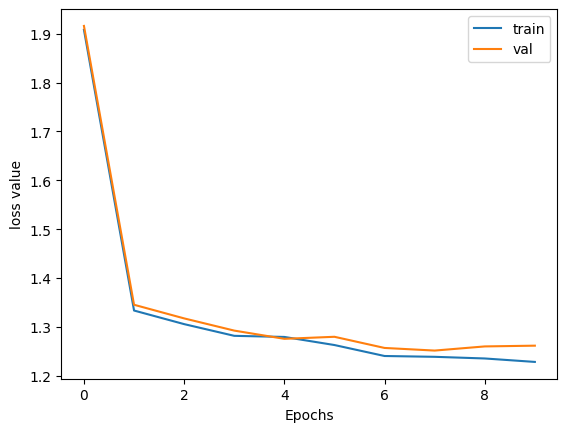

In [ ]:
loss_train = []
loss_val = []
for v in training_data["0"]:
    loss_train += v["train"]["loss"]
    loss_val += v["validation"]["loss"]
x = [i for i in range(len(loss_train))]
plt.plot(x, loss_train, label="train")
plt.plot(x, loss_val, label="val")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("loss value")
plt.savefig(f"loss_folds_0.pdf", format="pdf")
plt.show()

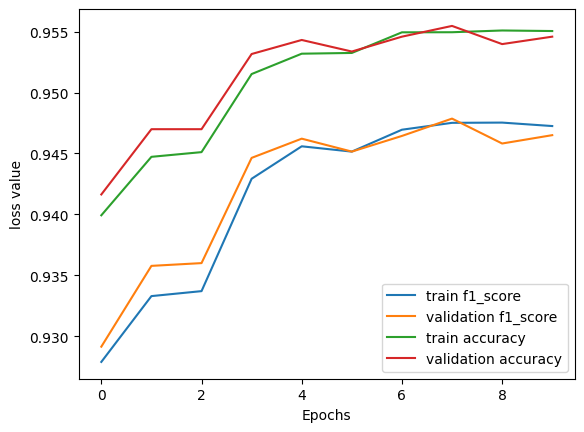

In [292]:
metrics = ["f1_score", "accuracy"]
m_data = {m: {"train": [], "validation": []} for m in metrics}
for v in training_data["0"]:
    for m in metrics:
        m_data[m]["train"] += v["train"][m]
        m_data[m]["validation"] += v["validation"][m]
x = [i for i in range(10)]
for m in metrics:
    plt.plot(x, m_data[m]["train"], label=f"train {m}")
    plt.plot(x, m_data[m]["validation"], label=f"validation {m}")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("loss value")
plt.savefig(f"metrics_folds_0.pdf", format="pdf")
plt.show()

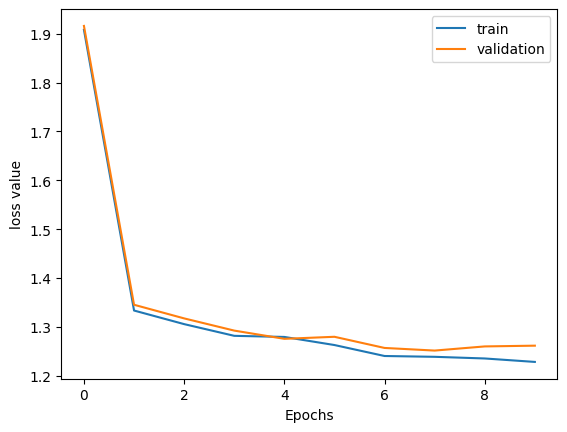

In [ ]:

training_data = {}
for file in os.listdir("../faulty_data"):
    if "extra" in file:
        continue
    fold = file.split("_mult_")[0].replace("fold_","")
    mult = 2 if "2" in file.split("_mult_")[1] else 1
    time = "init" if "init" in file.split("_mult_")[1] else "fin"
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join("../faulty_data", file))
    if mult == 2:
        training_data[fold][0] = json.load(f)
    elif mult == 1:
        if time == "init":
            training_data[fold][1] = json.load(f)
        else:
            training_data[fold][2] = json.load(f)
    f.close()
for fold in training_data.keys():
    res = []
    for i in range(3):
        res += [training_data[fold][i]]
    training_data[fold] = res
loss_train = []
loss_val = []
for v in training_data["0"]:
    loss_train += v["train"]["loss"]
    loss_val += v["validation"]["loss"]
x = [i for i in range(len(loss_train))]
plt.plot(x, loss_train, label="train")
plt.plot(x, loss_val, label="validation")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("loss value")
plt.savefig("loss_fully_neural_0.pdf", format="pdf")
plt.show()

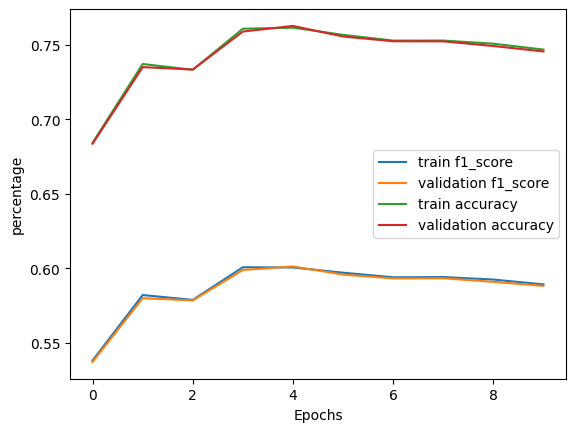

In [ ]:

metrics = ["f1_score", "accuracy"]
m_data = {m: {"train": [], "validation": []} for m in metrics}
for v in training_data["0"]:
    for m in metrics:
       m_data[m]["train"] += v["train"][m]
       m_data[m]["validation"] += v["validation"][m]
x = [i for i in range(10)]
for m in metrics:
    plt.plot(x, m_data[m]["train"], label=f"train {m}")
    plt.plot(x, m_data[m]["validation"], label=f"validation {m}")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("percentage")
plt.savefig("metrics_fully_neural_0.pdf", format="pdf")
plt.show()

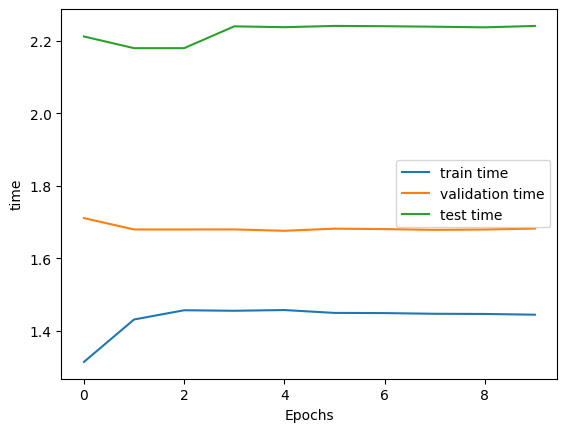

In [ ]:

x = [i for i in range(10)]
plt.plot(x, [(t - times_epocs[0]["vb_train"])/(times_epocs[0]["sb_train"] - times_epocs[0]["vb_train"]) for t in times_epocs[0]["train"]], label=f"train time")
plt.plot(x, [(t - times_epocs[0]["vb_validation"])/(times_epocs[0]["sb_validation"] - times_epocs[0]["vb_validation"]) for t in times_epocs[0]["validation"]], label=f"validation time")
plt.plot(x, [(t - times_epocs[0]["vb_test"])/(times_epocs[0]["sb_test"] - times_epocs[0]["vb_test"]) for t in times_epocs[0]["test"]], label=f"test time")
plt.legend()

plt.xlabel("Epochs")
plt.legend()

# plt.title("Training fold 0")
plt.ylabel("time")
plt.savefig("times_fully_neural_0.pdf", format="pdf")
plt.show()

# times

In [ ]:
f = open("../features/CarSequencing/CarSequencing_fold_0.json")
dnn = json.load(f)
f.close()

In [ ]:
dnn[0].keys()

dict_keys(['inst', 'features', 'time'])

In [ ]:
times = []
for f in dnn:
    times.append(f["time"])

In [ ]:
import numpy as np

In [ ]:
fixed = [t for t in autofolio_times if t > 0]

In [ ]:
np.min(fixed)

2.384185791015625e-07